# FEM Modelling for Single-Phase STEDIN Transformer

### Transient Analysis

In time-domain,
\begin{equation}
    -\nabla\cdot\Big[\frac{1}{\mu}\nabla u_z \Big] + \sigma \frac{\partial u_z}{\partial t} = J_0
\end{equation}

Writing in matrix form, 
\begin{equation}
    Au + B \frac{\partial u}{\partial t} = f
\end{equation}

Using Backward Euler method for time-stepping, 
\begin{equation}
    Au^{t+\Delta t} + B \frac{u^{t+\Delta t} - u^{t}}{\Delta t} = f^{t+\Delta t}
\end{equation}

On simplifying, we get,
\begin{equation}
    [B + \Delta t A]u^{t+\Delta t} = Bu^t + \Delta t f^t
\end{equation}

## Import Packages

In [1]:
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
include("../../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../../lib/FEM_Transient_Tri_1e.jl");
using .FEM_Transient_Tri_1e
include("../../../../lib/Post_Process_Time.jl");
using .Post_Process_Time
include("../../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../../lib/Save_VTK.jl");
using .Save_VTK

## Julia code

In [2]:
gmsh.initialize()

## Read mesh from file
gmsh.open("../../../../Geometry/mesh/stedin_transformer.msh")

mesh_data = get_mesh_data_tri_1e(gmsh)

Ip = 17.54;   # Primary peak phase current
Is = 0;  # Secondary peak phase current
Np = 266;
Ns = 6;

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate current density in the windings
Jp = Np * Ip / Awhv;
Js = Ns * Is / Awlv;

# Specify time start, end and step
init_time = 0
n_cycles = 2
final_time = n_cycles*(2*pi/omega)
dt = (final_time-init_time) / (100*n_cycles)
time_steps = Vector(init_time:dt:final_time)

# Source current density J
# One term for each of the windings, with a positive and negative part
# Note the phase shift between the phases
sourcefunction(group_id) = Jp * (-1 * (group_id==5) + 1 * (group_id==6)) + 
                           Js * (1 * (group_id==11) - 1 * (group_id==12));
sourceperelement = map(sourcefunction, mesh_data.e_group);
phi_diff = pi/3;

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2.5e4;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

# Calculate the vector potential
@time u = fem_third_harmonic(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, time_steps, phi_diff);

# Post-process for magnetic field and current density
@time Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement, time_steps);

gmsh.finalize()

Info    : Reading '../../../../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../../../../Geometry/mesh/stedin_transformer.msh'
  6.410465 seconds (13.28 M allocations: 1.167 GiB, 3.44% gc time, 80.71% compilation time)
 10.012264 seconds (92.59 M allocations: 4.819 GiB, 7.81% gc time, 7.89% compilation time)


## Plots

In [3]:
selected_node = 4276
selected_element = 7051
u_wave = [u_curr[selected_node] for u_curr in u];
Bx_wave = [Bx_curr[selected_element] for Bx_curr in Bx];
By_wave = [By_curr[selected_element] for By_curr in By];
B_wave = [B_curr[selected_element] for B_curr in B];
Hx_wave = [Hx_curr[selected_element] for Hx_curr in Hx];
Hy_wave = [Hy_curr[selected_element] for Hy_curr in Hy];
H_wave = [H_curr[selected_element] for H_curr in H];
mag_energy_wave = [mag_energy_curr[selected_element] for mag_energy_curr in mag_energy];

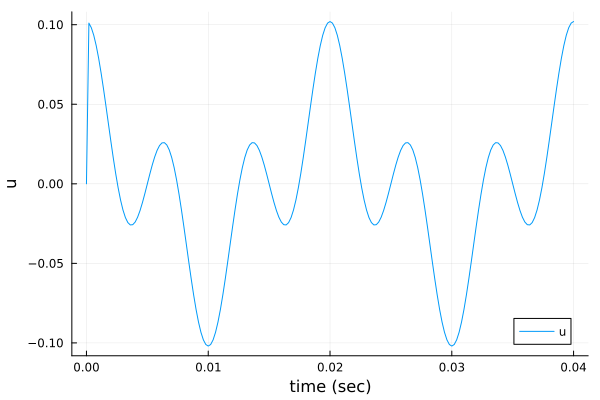

In [4]:
plot(time_steps, real(u_wave), label = "u")
xlabel!("time (sec)")
ylabel!("u")

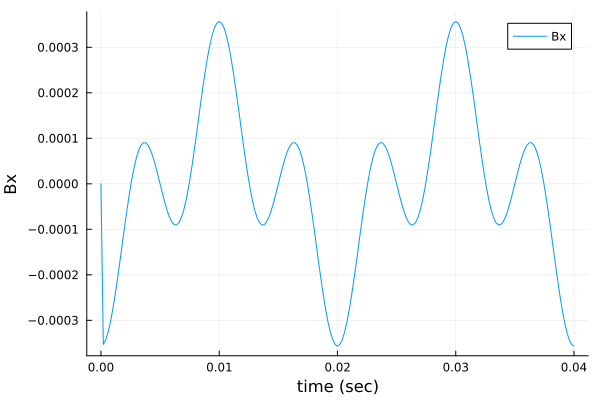

In [5]:
plot(time_steps, real(Bx_wave), label = "Bx")
xlabel!("time (sec)")
ylabel!("Bx")

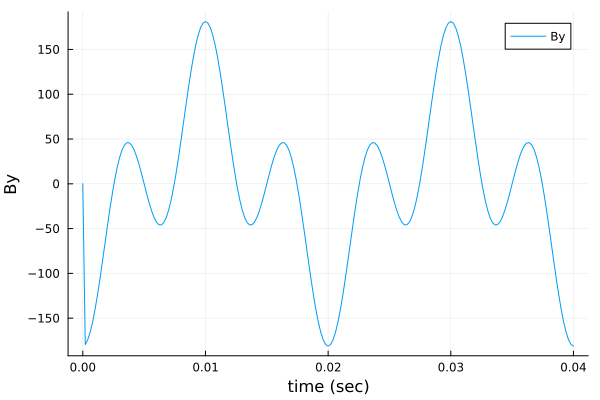

In [6]:
plot(time_steps, real(By_wave), label = "By")
xlabel!("time (sec)")
ylabel!("By")

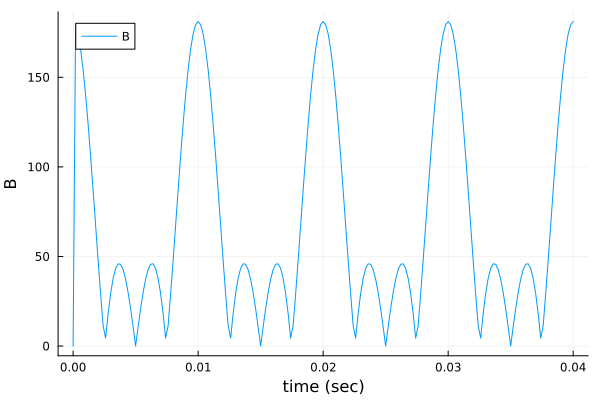

In [7]:
plot(time_steps, real(B_wave), label = "B")
xlabel!("time (sec)")
ylabel!("B")

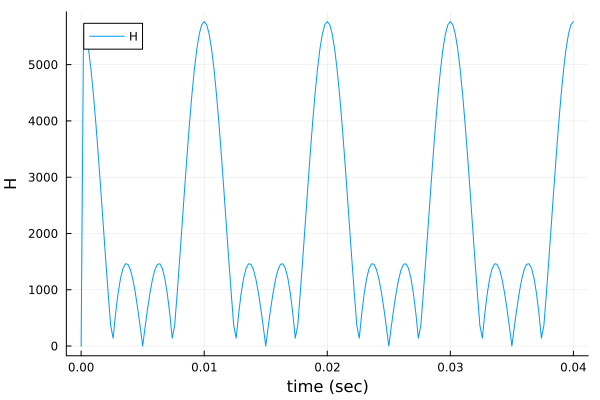

In [8]:
plot(time_steps, real(H_wave), label = "H")
xlabel!("time (sec)")
ylabel!("H")

In [9]:
Bx_mat = DataFrame(real(hcat(Bx...)), :auto)
CSV.write("../csv/single_phase_harmonic_stedin_transformer_Bx_trasient.csv", Bx_mat)
By_mat = DataFrame(real(hcat(By...)), :auto)
CSV.write("../csv/single_phase_harmonic_stedin_transformer_By_trasient.csv", By_mat)
B_mat = DataFrame(real(hcat(B...)), :auto)
CSV.write("../csv/single_phase_harmonic_stedin_transformer_B_trasient.csv", B_mat)
Hx_mat = DataFrame(real(hcat(Hx...)), :auto)
CSV.write("../csv/single_phase_harmonic_stedin_transformer_Hx_trasient.csv", Hx_mat)
Hy_mat = DataFrame(real(hcat(Hy...)), :auto)
CSV.write("../csv/single_phase_harmonic_stedin_transformer_Hy_trasient.csv", Hy_mat)
H_mat = DataFrame(real(hcat(H...)), :auto)
CSV.write("../csv/single_phase_harmonic_stedin_transformer_H_trasient.csv", H_mat)
mag_energy_mat = DataFrame(real(hcat(mag_energy...)), :auto)
CSV.write("../csv/single_phase_harmonic_stedin_transformer_mag_energy_trasient.csv", mag_energy_mat)

LoadError: SystemError: opening file "../csv/single_phase_harmonic_stedin_transformer_Bx_trasient.csv": No such file or directory